# Análise não-linear de séries temporais
Este tipo de análise consiste em um conjunto de metodologias que começaram a ser desenvolvidas na década de 1990 com a finalidade de estudar sistemas complexos. Uma [boa revisão](https://aip.scitation.org/doi/pdf/10.1063/1.4917289?casa_token=J6ENq2j7UZYAAAAA:zHvGR93etcwS0jZPxq1Gu3sw1xPcVefi89Qh3lepPIFxUm6zkQcdnGPXPVbR3Rvo9qg_LFdtlMzQ) deste assunto nos informa que se trata de buscar caracterizar o sistema dinâmico por trás do fenômeno estudado, frequentemente, um sistema caótico deterministico.

In [34]:
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score as MI
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 10.0)

## Reconstrução do espaço de estados
A reconstrução do espaço de estados do sistema dinâmico é a pedra fundamental desta metodologia. Para isso normalmente usamos Retratos de fase $m$-dimensionais atrasados da nossa série $y(t)$:

$$\overrightarrow{R}(t)=\left[y(t), y(t-\tau), y(t-2\tau),\ldots,y(t-(m-1)\tau)\right]$$

Vamos explorar esta reconstrução com uma série simulada a partir das equações de Rössler.

\begin{align}
\frac{dx}{dt}&=-y-z\\
\frac{dy}{dt}&=x+a y\\
\frac{dz}{dt}&=b + z  (x - c)
\end{align}

In [4]:
def rossler(Y,t,*pars):
    x,y,z = Y
    a,b,c = pars
    return [
        -y-z,
        x+(a*y),
        b+z*(x-c)
    ]

In [5]:
inits = [4,4,5]
a,b,c = 0.2, 0.2, 5.7
trange = range(20000)
res = odeint(rossler,inits,trange, args=(a,b,c))

<IPython.core.display.Javascript object>


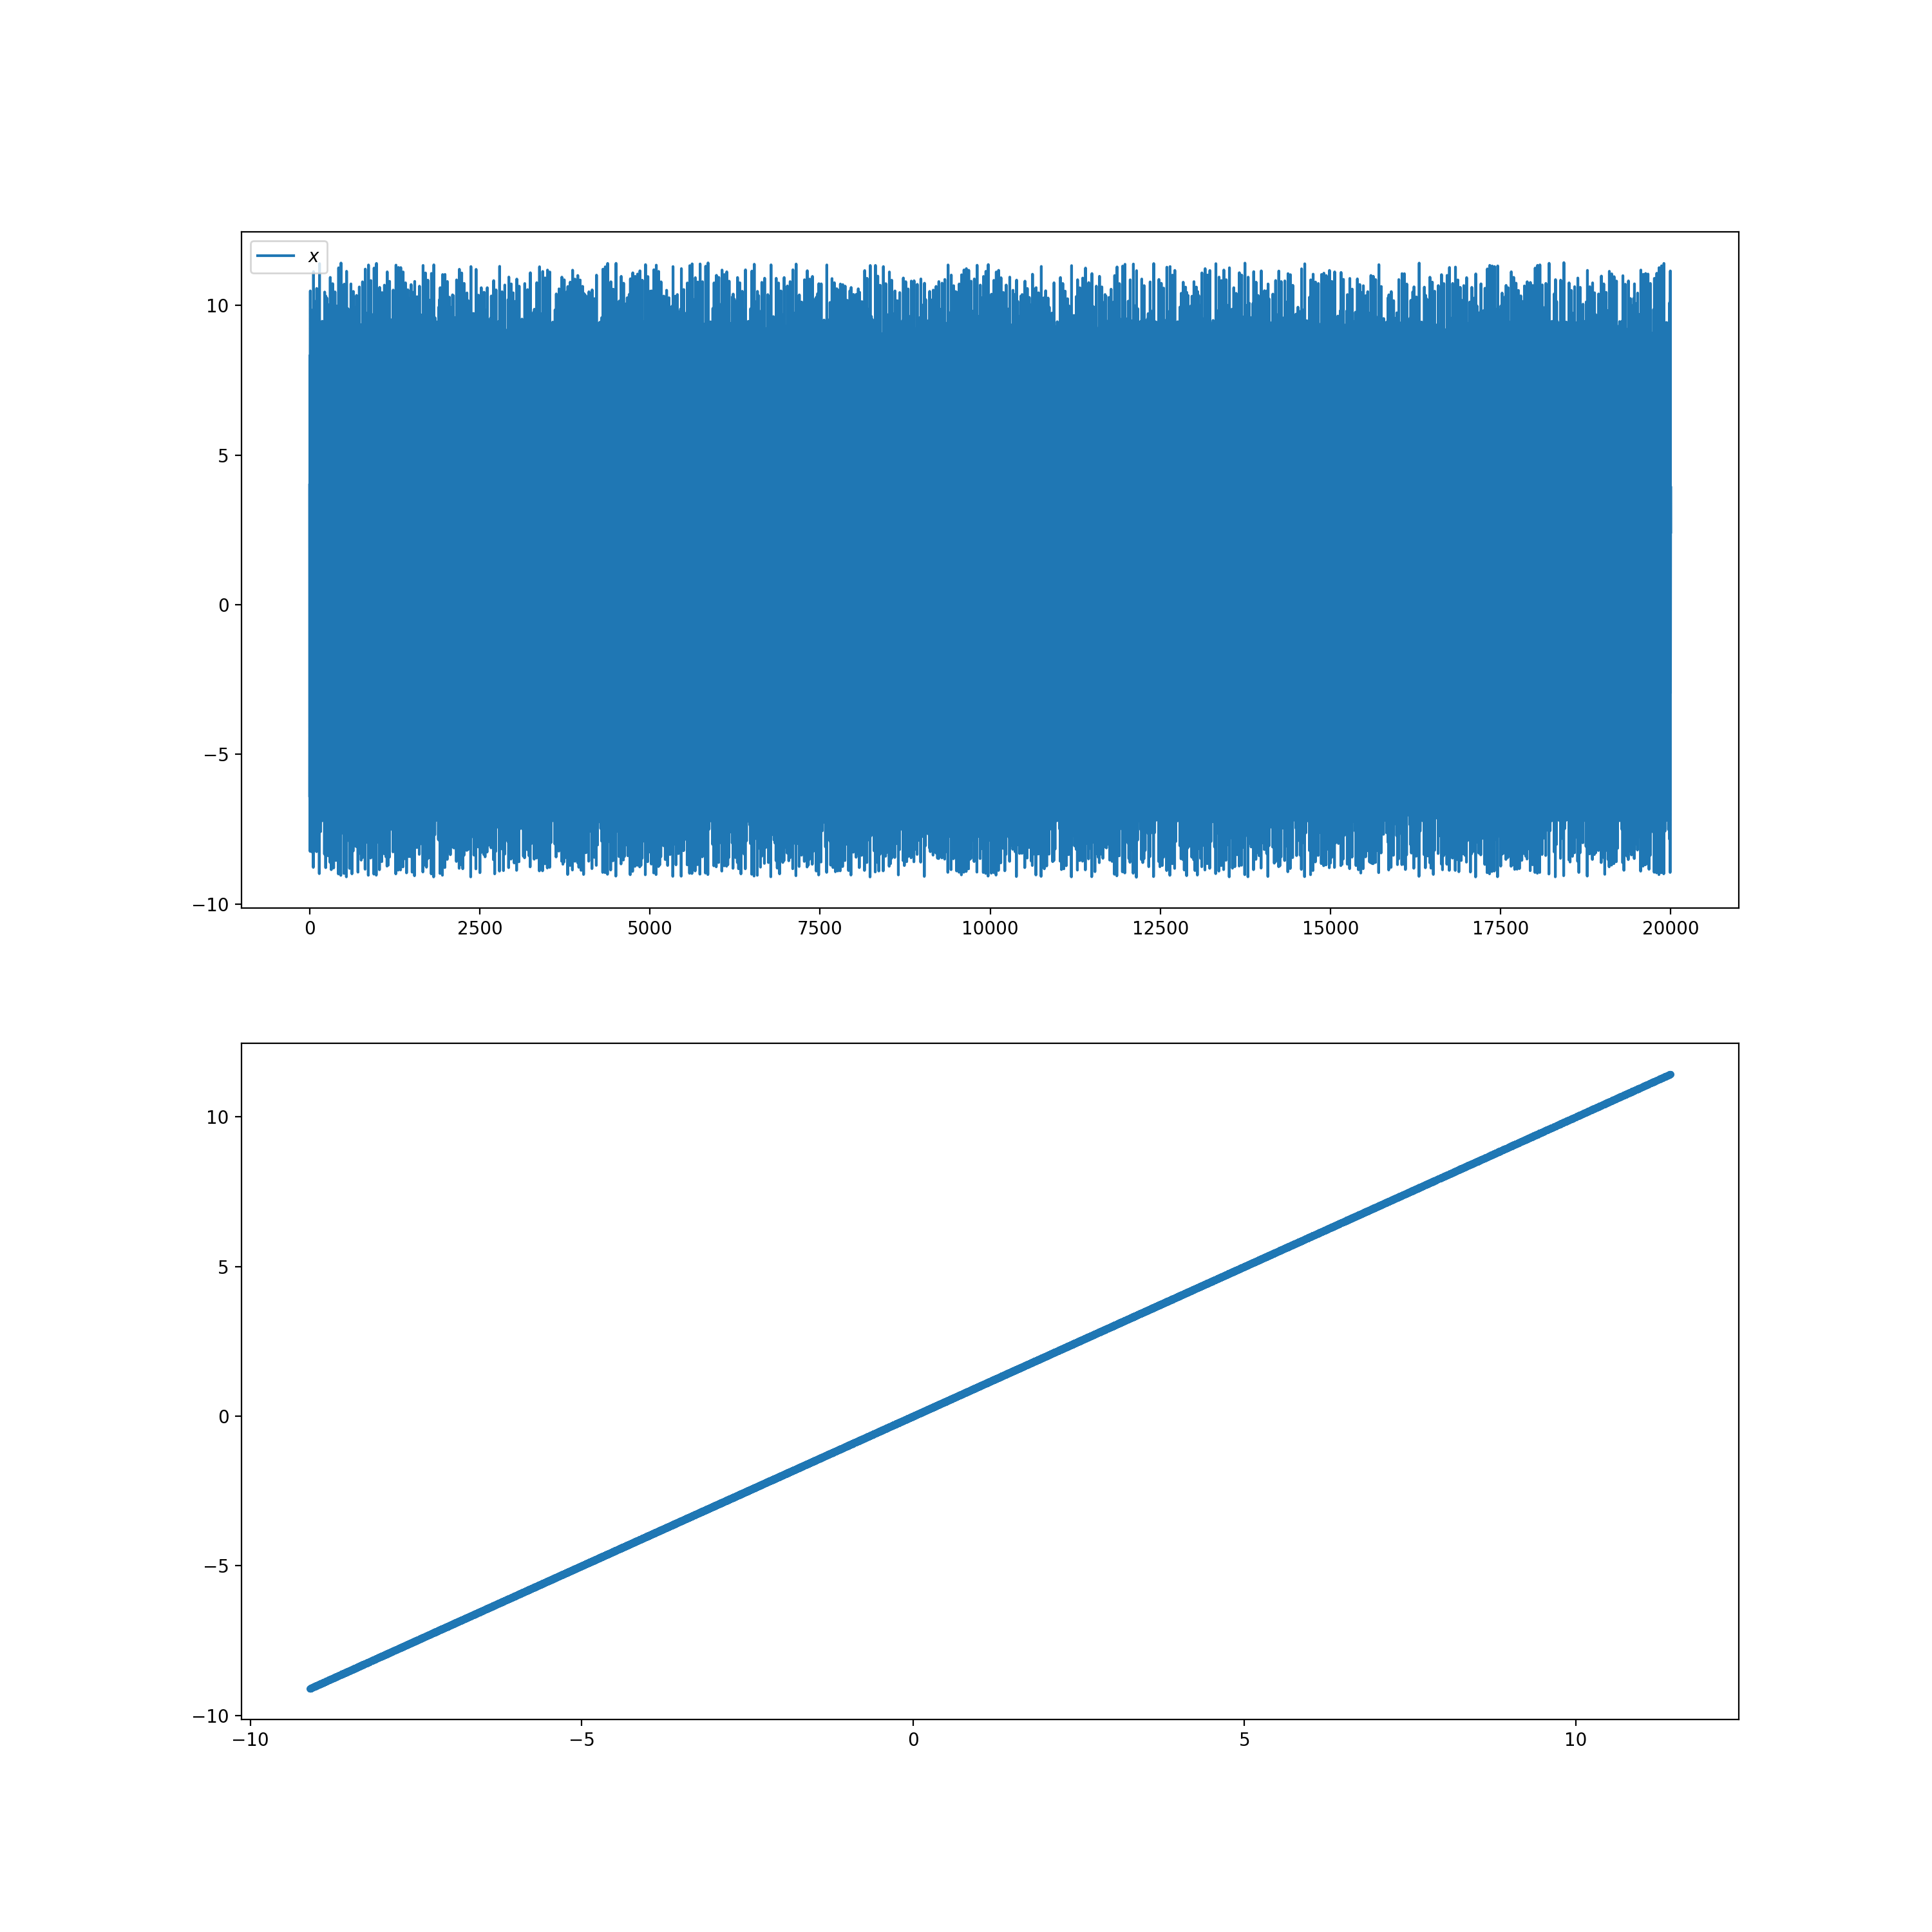

In [9]:
f,[ax1,ax2] = plt.subplots(2,1,figsize=(15,15))
ax1.plot(res[:,0], label='$x$');
ax1.legend()
ax2.plot(res[:,0],res[:,0], '.');

A series atrasadas com valores de $\tau$ pequenos, tendem a ser muito correlacionadas. Portanto a escolha de $\tau$ é importante. Abaixo temos uma figura interativa que nos permite visualizar o atrator do sistema em 3 dimensões para vários valores de $\tau$. Uma das maneiras mais comuns de se estima o melhor valor de $\tau$ é através da [informação mútua](https://en.wikipedia.org/wiki/Mutual_information) entre as séries, queremos encontrar o menor valor de tau, que minimiza a informação mútua.

Para simplicidade de cálculo podemos obter a informação mútual a partir da correlação
$$I=-\frac{1}{2}log(1-\rho^2)$$

Esta aproximação pressupões que ambas as séries têm distribuição Gaussiana.

In [12]:
@interact(tau=widgets.IntSlider(7,0,40,1))
def embed(tau):
    fig = plt.figure()
    ax=fig.gca(projection='3d')
    x,y,z = res[:-2*tau,0],res[tau:-tau,0], res[2*tau:,0]
    mi = MI(x,y)
    ax.plot(x,y,z, '.', alpha=0.5)
    ax.set_title(fr'$\tau={tau}$, Mutual information: {mi}')
    ax.set_xlabel(f'$x$')
    ax.set_ylabel(f'$x+{tau}$')
    ax.set_zlabel(f'$x+{2*tau}$')
    

interactive(children=(IntSlider(value=1, description='tau', max=40), Output()), _dom_classes=('widget-interact…

<IPython.core.display.Javascript object>


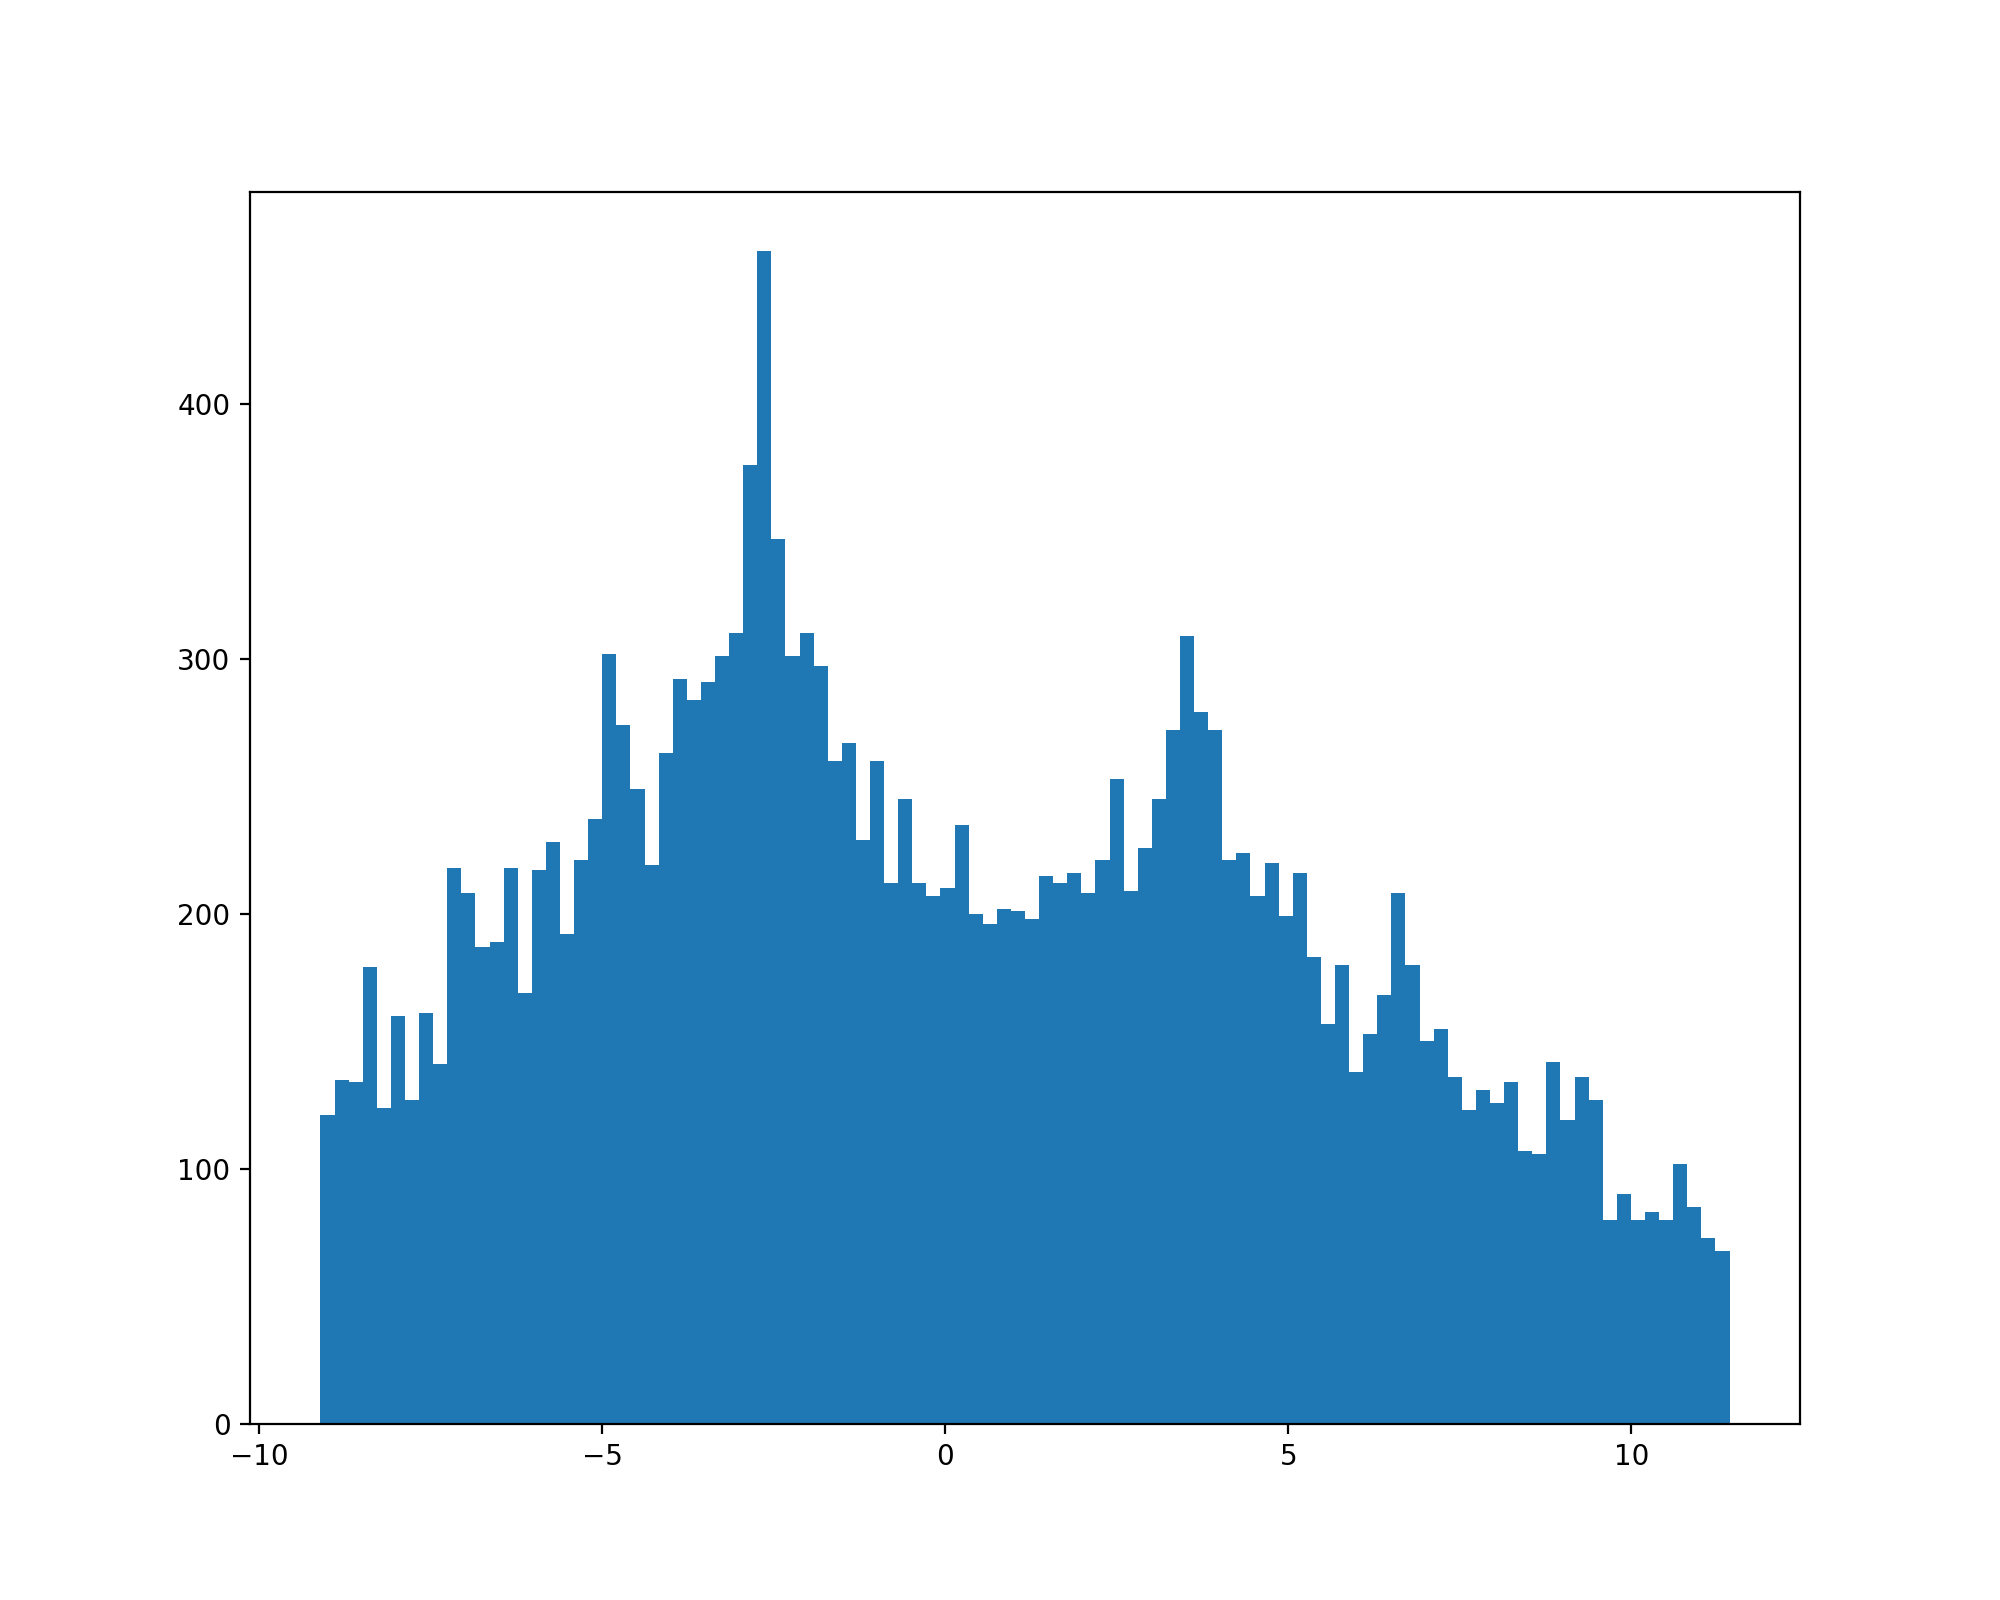

In [14]:
# Verificando a distibuição da série.
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(res[:,0],bins=100);

<IPython.core.display.Javascript object>


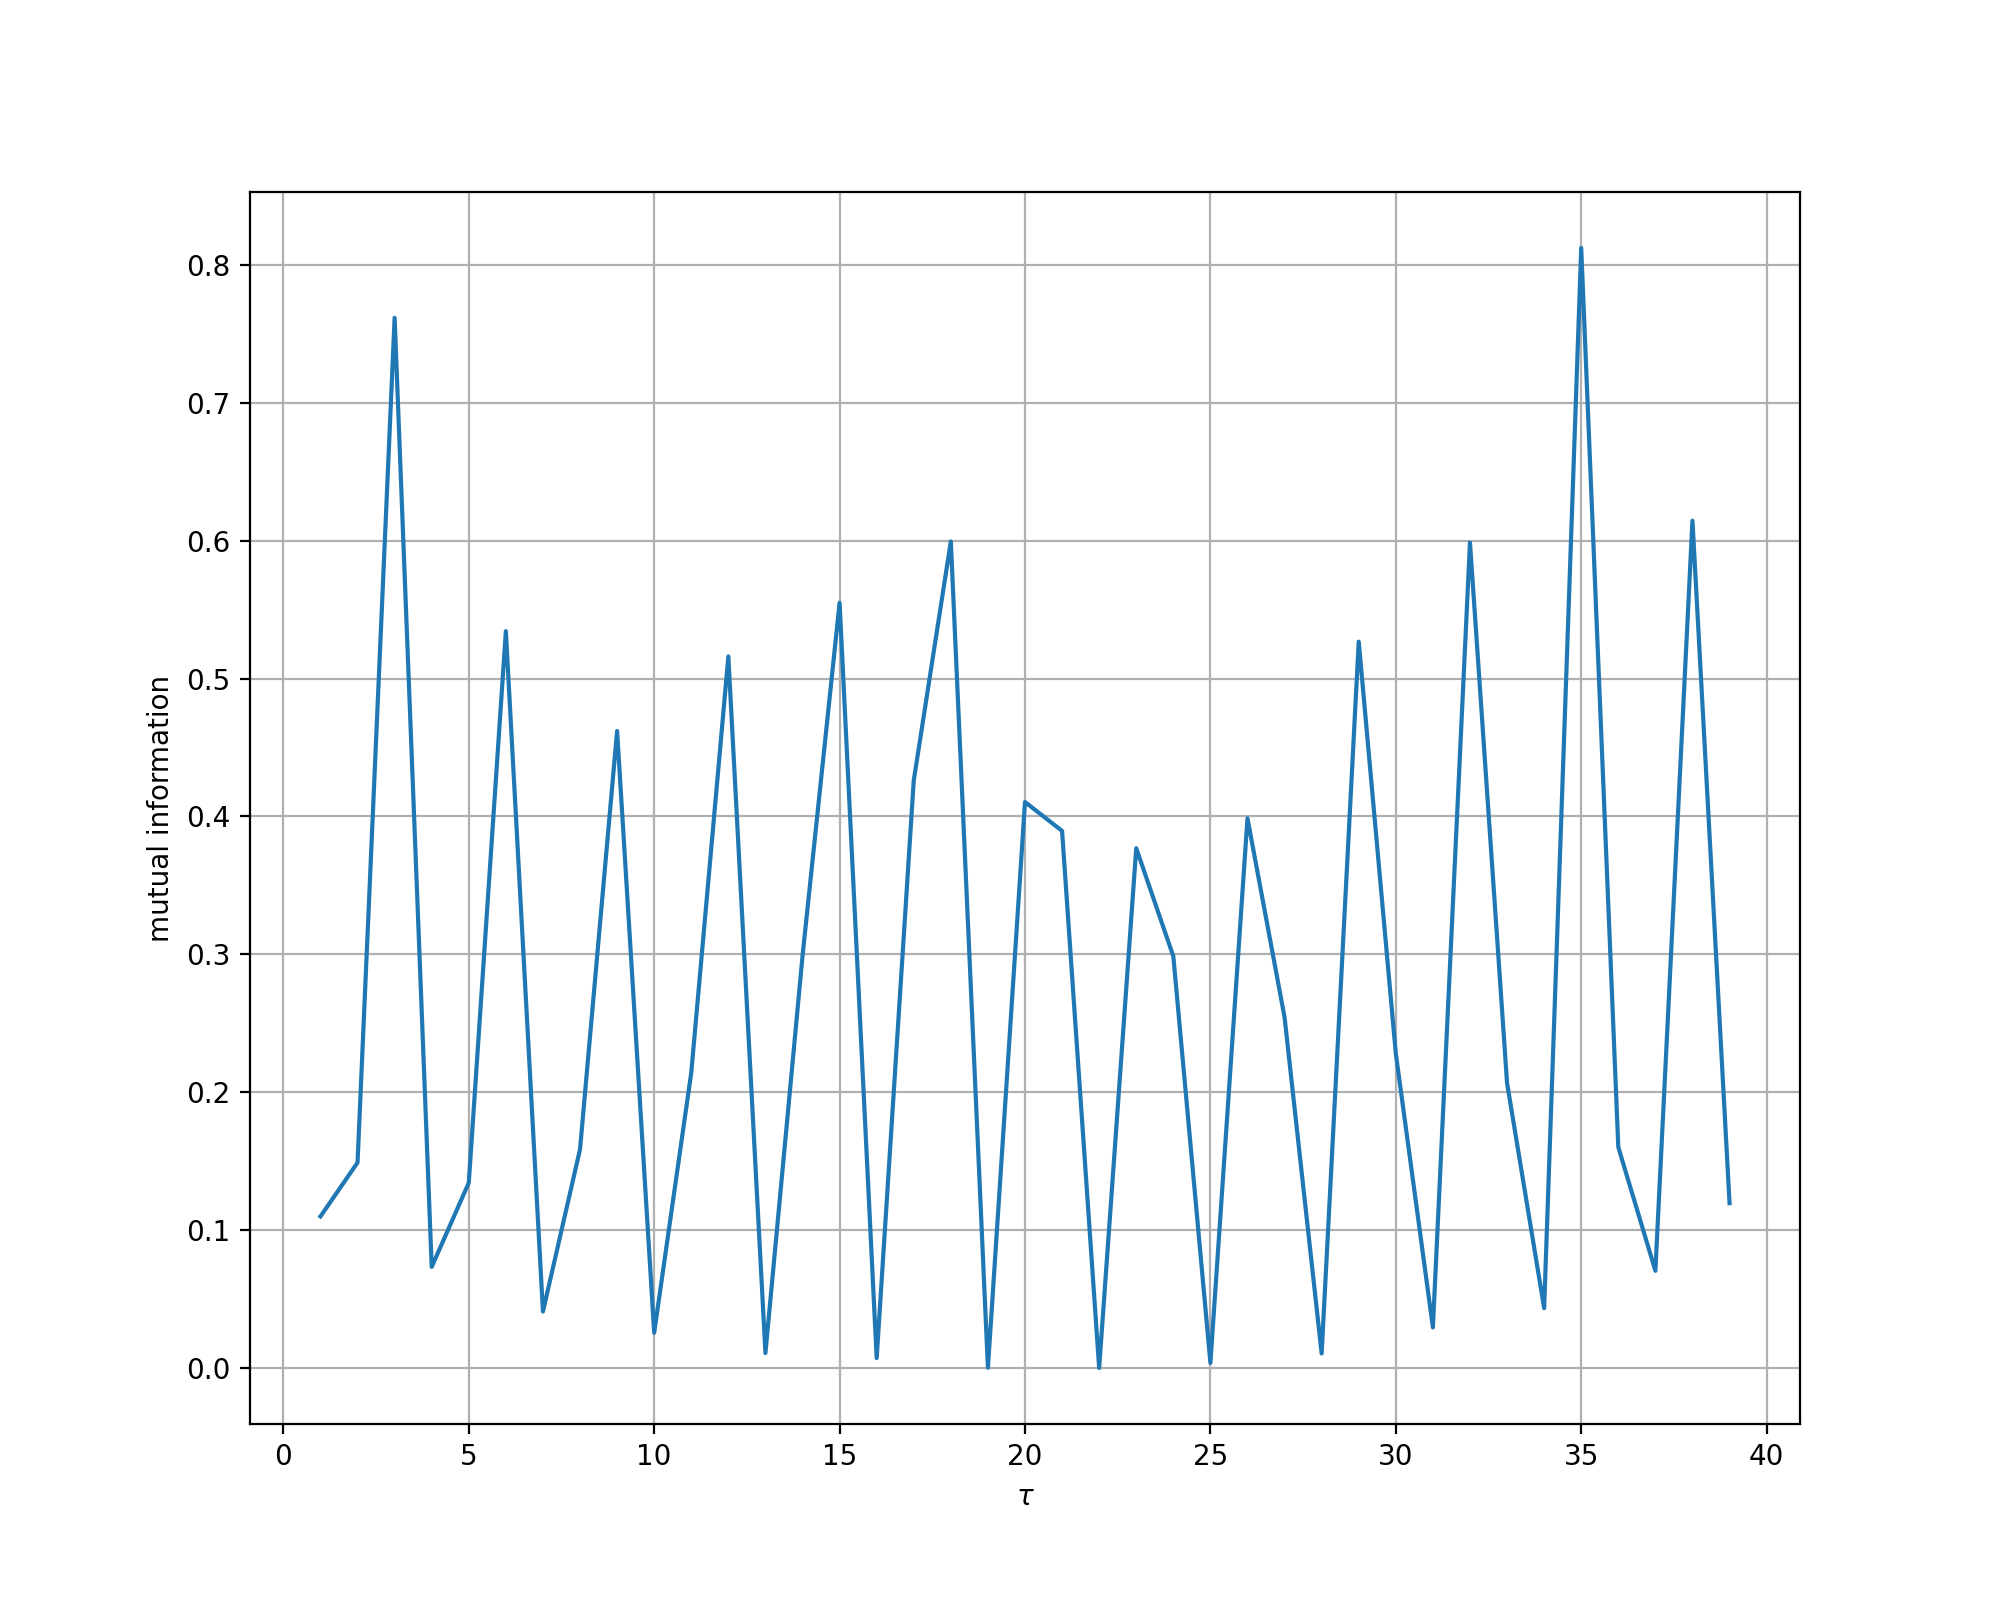

Text(0, 0.5, 'mutual information')

In [19]:
mis = []
for tau in range(1,40):
    mis.append(-0.5*np.log(1-pearsonr(res[:-tau,0],res[tau:,0])[0]**2))
#     mis.append(MI(res[:-tau,0],res[tau:,0]))
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(range(1,40),mis)
ax.grid()
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'mutual information')

## Estimando $m$, a dimensão de embedding
Para esta parte vamos nos utilizar da biblioteca [nolds](https://github.com/CSchoel/nolds): Non-linear measures for Dynamical Systems. Nela temos a implementação do algoritmo  de Grassberger-Procaccia para cálculo da dimensão de correlação. Também vamos usar a biblioteca [Neurokit2](https://neurokit2.readthedocs.io) para estimação de dimensão de embedding.

In [30]:
import nolds
import neurokit2 as nk

In [31]:
nolds.corr_dim(res[:,0],4)

1.7979750803415464

{'delay': 4, 'dimension': 4, 'r': 0.6193779146523386}

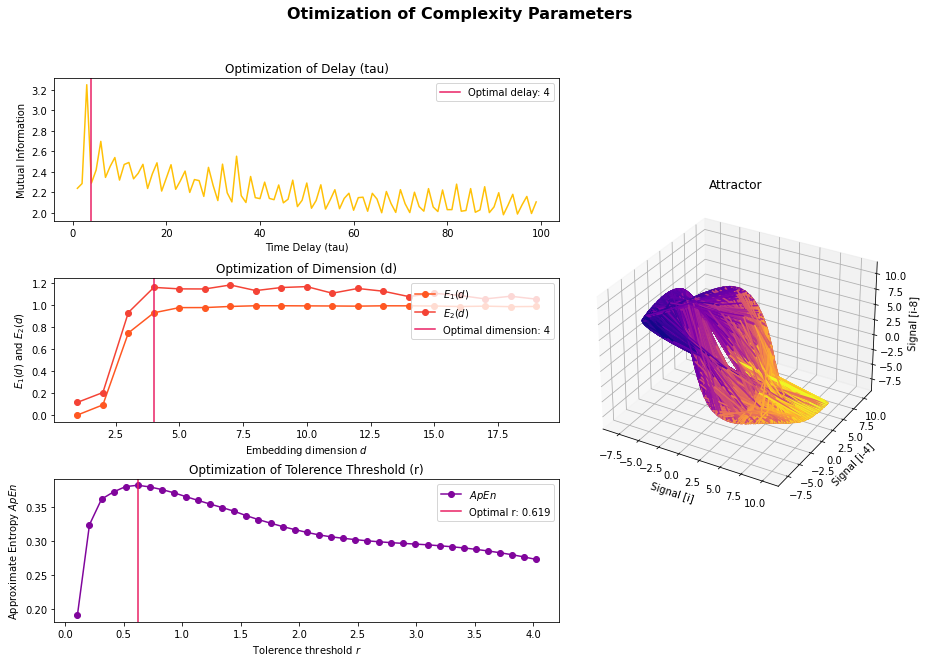

In [35]:
parameters = nk.complexity_optimize(res[:,0], show=True)
parameters

## Fazendo previsões a partir do sinal reconstruído.
Para testar a utilidade da reconstrução realizada, vamos utilizar uma regressão usando Kernel regression e também Lightgbm.

In [105]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from statsmodels.nonparametric.kernel_regression import KernelReg

In [40]:
data = pd.DataFrame(data={'ts':res[:,0]})
tau = 4
data['lag1'] = data.ts.shift(1*tau)
data['lag2'] = data.ts.shift(2*tau)
data['lag3'] = data.ts.shift(3*tau)
data['lag4'] = data.ts.shift(4*tau)
data

,ts,lag1,lag2,lag3,lag4
0,4.000000,NaN,NaN,NaN,NaN
1,-2.701291,NaN,NaN,NaN,NaN
2,-6.424261,NaN,NaN,NaN,NaN
3,-4.422475,NaN,NaN,NaN,NaN
4,2.517592,4.000000,NaN,NaN,NaN
...,...,...,...,...,...
19995,-2.921642,-4.679059,7.140714,-3.954312,-5.143011
19996,-1.382961,5.279095,2.531852,-5.201302,3.361338
19997,1.899994,11.153827,-4.979770,-1.427417,10.091506
19998,3.954745,-1.584968,-8.944661,4.618631,1.552838


Agora vamos remover as primeiras linhas que contém `NaN`s

In [42]:
data = data.dropna()
data

,ts,lag1,lag2,lag3,lag4
16,4.044545,0.925383,-8.239929,2.517592,4.000000
17,4.859027,-3.280940,-6.255662,8.328219,-2.701291
18,0.920742,-3.366459,2.529070,5.158565,-6.424261
19,-4.702702,-0.042813,10.486560,-2.988373,-4.422475
20,-6.760360,4.044545,0.925383,-8.239929,2.517592
...,...,...,...,...,...
19995,-2.921642,-4.679059,7.140714,-3.954312,-5.143011
19996,-1.382961,5.279095,2.531852,-5.201302,3.361338
19997,1.899994,11.153827,-4.979770,-1.427417,10.091506
19998,3.954745,-1.584968,-8.944661,4.618631,1.552838


### Kernel regression
Vamos usar a biblioteca statsmodels para ajustar a [regressão de kernel](https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.kernel_regression.KernelReg.html#statsmodels.nonparametric.kernel_regression.KernelReg) nãp paramétrica. Para economizar tempo, vamos ajustar a regressão por Kernel utilizando apenas os primeiros 500 pontos. So we will use only the first 500 points to fit the regression model.

In [85]:
model = KernelReg(data.ts[17:517], data[['lag1','lag2','lag3','lag4']][:500],var_type=['c','c','c','c'])

Agora vamos usar os 500 pontos seguintes para testar o poder preditivo do modelo.

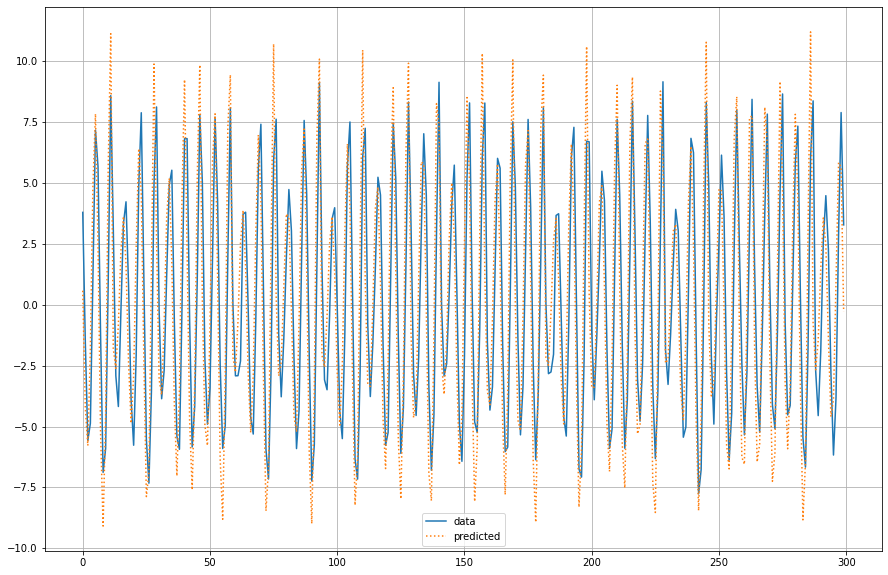

In [88]:
m,marg = model.fit(data_predict=data[['lag1','lag2','lag3','lag4']][517:817])
plt.plot(m, label='data')
plt.plot(range(300),data.ts[517:817],':',label='predicted')
plt.grid()
plt.legend();

In [89]:
model.r_squared()

0.9304935915980965

### LightGBM regression

In [99]:
train_size = 1000
dftrain = data[['lag1','lag2','lag3','lag4']][:train_size]
dftest = data[['lag1','lag2','lag3','lag4']][train_size+17:train_size+17+300]
Y = data.ts[17:train_size+17]

In [91]:
X_train, X_test, y_train, y_test = train_test_split( dftrain, Y, test_size=0.2, random_state=42)

In [92]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

In [93]:
gbm = lgb.LGBMRegressor(**hyper_params)


In [94]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's l1: 2.73678	valid_0's l2: 10.7764	valid_0's auc: 0.986399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's l1: 2.72581	valid_0's l2: 10.6939	valid_0's auc: 0.986399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's l1: 2.71493	valid_0's l2: 10.6122	valid_0's auc: 0.986299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's l1: 2.70408	valid_0's l2: 10.5314	valid_0's auc: 0.986299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's l1: 2.69326	valid_0's l2: 10.4513	valid_0's auc: 0.986299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's l1: 2.68253	valid_0's l2: 10.3722	valid_0's auc: 0.986499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's l1: 2.67196	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's l1: 1.92057	valid_0's l2: 5.32409	valid_0's auc: 0.986299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's l1: 1.9161	valid_0's l2: 5.29812	valid_0's auc: 0.986299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's l1: 1.91172	valid_0's l2: 5.27272	valid_0's auc: 0.986299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's l1: 1.90739	valid_0's l2: 5.24779	valid_0's auc: 0.986299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's l1: 1.903	valid_0's l2: 5.22262	valid_0's auc: 0.986299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's l1: 1.8987	valid_0's l2: 5.19821	valid_0's auc: 0.986199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's l1: 1.89446	valid_0

[435]	valid_0's l1: 1.29714	valid_0's l2: 2.64585	valid_0's auc: 0.988099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's l1: 1.29605	valid_0's l2: 2.64271	valid_0's auc: 0.988199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's l1: 1.29478	valid_0's l2: 2.63895	valid_0's auc: 0.988199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's l1: 1.29374	valid_0's l2: 2.63589	valid_0's auc: 0.988199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's l1: 1.29251	valid_0's l2: 2.6322	valid_0's auc: 0.988199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's l1: 1.29137	valid_0's l2: 2.62847	valid_0's auc: 0.988199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's l1: 1.2901	valid_0's l2: 2.62479	valid_0's auc: 0.988199
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[662]	valid_0's l1: 1.12495	valid_0's l2: 2.19356	valid_0's auc: 0.988999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[663]	valid_0's l1: 1.12427	valid_0's l2: 2.19154	valid_0's auc: 0.988899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[664]	valid_0's l1: 1.12359	valid_0's l2: 2.18955	valid_0's auc: 0.988899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[665]	valid_0's l1: 1.12291	valid_0's l2: 2.18758	valid_0's auc: 0.988899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[666]	valid_0's l1: 1.12224	valid_0's l2: 2.18563	valid_0's auc: 0.988899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	valid_0's l1: 1.12157	valid_0's l2: 2.18371	valid_0's auc: 0.988899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[668]	valid_0's l1: 1.1209	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[898]	valid_0's l1: 1.05733	valid_0's l2: 2.05423	valid_0's auc: 0.988399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[899]	valid_0's l1: 1.05705	valid_0's l2: 2.05405	valid_0's auc: 0.988399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's l1: 1.05677	valid_0's l2: 2.0539	valid_0's auc: 0.988399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[901]	valid_0's l1: 1.0565	valid_0's l2: 2.05313	valid_0's auc: 0.988399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[902]	valid_0's l1: 1.05623	valid_0's l2: 2.05236	valid_0's auc: 0.988499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[903]	valid_0's l1: 1.05596	valid_0's l2: 2.05161	valid_0's auc: 0.988499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[904]	valid_0's l1: 1.05569	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[995]	valid_0's l1: 1.04415	valid_0's l2: 2.01819	valid_0's auc: 0.988499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[996]	valid_0's l1: 1.04409	valid_0's l2: 2.01798	valid_0's auc: 0.988499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[997]	valid_0's l1: 1.04403	valid_0's l2: 2.01778	valid_0's auc: 0.988499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[998]	valid_0's l1: 1.04398	valid_0's l2: 2.01759	valid_0's auc: 0.988499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[999]	valid_0's l1: 1.04392	valid_0's l2: 2.0174	valid_0's auc: 0.988499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's l1: 1.04388	valid_0's l2: 2.01721	valid_0's auc: 0.988499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1001]	valid_0's l1: 1.04373	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1132]	valid_0's l1: 1.03508	valid_0's l2: 1.96976	valid_0's auc: 0.988699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1133]	valid_0's l1: 1.03498	valid_0's l2: 1.96963	valid_0's auc: 0.988699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1134]	valid_0's l1: 1.03489	valid_0's l2: 1.9695	valid_0's auc: 0.988699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1135]	valid_0's l1: 1.03479	valid_0's l2: 1.96937	valid_0's auc: 0.988699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1136]	valid_0's l1: 1.0347	valid_0's l2: 1.96926	valid_0's auc: 0.988599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1137]	valid_0's l1: 1.0346	valid_0's l2: 1.96915	valid_0's auc: 0.988599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1138]	valid_0's l1: 1.03451

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1299]	valid_0's l1: 1.02157	valid_0's l2: 1.92663	valid_0's auc: 0.988499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1300]	valid_0's l1: 1.02136	valid_0's l2: 1.92619	valid_0's auc: 0.988599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1301]	valid_0's l1: 1.02114	valid_0's l2: 1.92599	valid_0's auc: 0.988599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1302]	valid_0's l1: 1.02092	valid_0's l2: 1.92579	valid_0's auc: 0.988599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1303]	valid_0's l1: 1.02072	valid_0's l2: 1.92564	valid_0's auc: 0.988599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1304]	valid_0's l1: 1.02051	valid_0's l2: 1.92546	valid_0's auc: 0.988599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1305]	valid_0's l1: 1.02

[1423]	valid_0's l1: 1.01367	valid_0's l2: 1.90039	valid_0's auc: 0.988699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1424]	valid_0's l1: 1.01336	valid_0's l2: 1.89975	valid_0's auc: 0.988699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1425]	valid_0's l1: 1.01305	valid_0's l2: 1.89901	valid_0's auc: 0.988699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1426]	valid_0's l1: 1.01274	valid_0's l2: 1.89838	valid_0's auc: 0.988699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1427]	valid_0's l1: 1.01244	valid_0's l2: 1.89766	valid_0's auc: 0.988699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1428]	valid_0's l1: 1.01214	valid_0's l2: 1.89694	valid_0's auc: 0.988699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1429]	valid_0's l1: 1.01184	valid_0's l2: 1.89624	valid_0's auc: 0.988799
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1591]	valid_0's l1: 1.00554	valid_0's l2: 1.86956	valid_0's auc: 0.988799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1592]	valid_0's l1: 1.00545	valid_0's l2: 1.86947	valid_0's auc: 0.988799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1593]	valid_0's l1: 1.00536	valid_0's l2: 1.86938	valid_0's auc: 0.988799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1594]	valid_0's l1: 1.00527	valid_0's l2: 1.8693	valid_0's auc: 0.988799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1595]	valid_0's l1: 1.00526	valid_0's l2: 1.86932	valid_0's auc: 0.988799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1596]	valid_0's l1: 1.00525	valid_0's l2: 1.86934	valid_0's auc: 0.988799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1597]	valid_0's l1: 1.005

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l2', 'auc'], n_estimators=1000, num_iterations=100000,
              num_leaves=128, objective='regression', task='train', verbose=0)

In [95]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

In [107]:
# Basic MAE
print('The MAE of prediction is:', round(mean_absolute_error(y_pred, y_train) ** 0.5, 5))

The MAE of prediction is: 0.98626


Testando fora da amostra

In [100]:
y_pred_out = gbm.predict(dftest, num_iteration=gbm.best_iteration_)

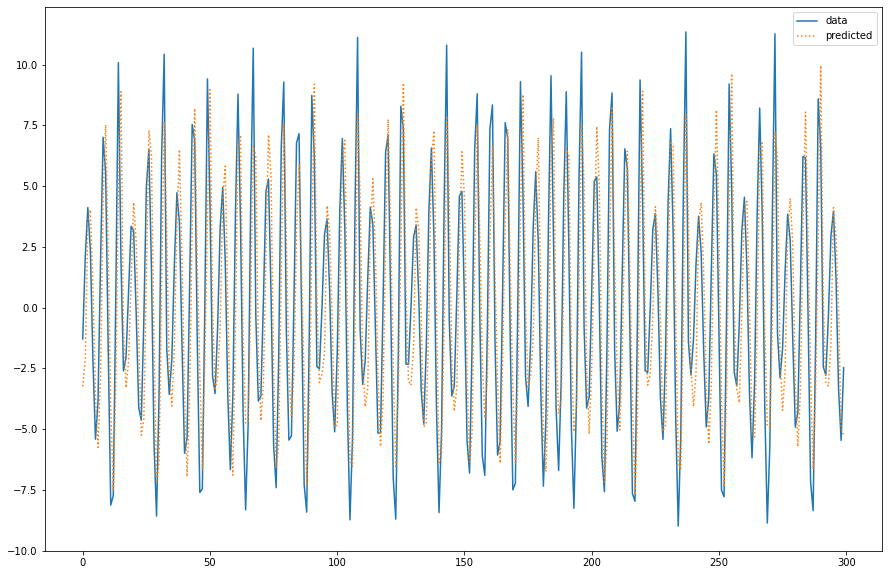

In [101]:
plt.plot(range(300),data.ts[train_size+17:train_size+17+300], label='data')
plt.plot(y_pred_out,':',label='predicted')
plt.legend();

In [108]:
y_pred_out# Basic RMSE
print('The MAE of prediction is:', round(mean_absolute_error(y_pred_out,data.ts[train_size+17:train_size+17+300]) ** 0.5, 5))

The MAE of prediction is: 1.67362
